In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import matplotlib
import scipy
print('Matplotlib Version:{}'.format(matplotlib.__version__))
print('Numpy Version:{}'.format(np.__version__))
print('Pandas Version:{}'.format(pd.__version__))
print('Scipy Version:{}'.format(scipy.__version__))

Matplotlib Version:3.3.2
Numpy Version:1.19.2
Pandas Version:1.0.5
Scipy Version:1.5.0


In [3]:
motor_d = pd.read_csv('../etc/motor_direito_0.csv')
motor_e = pd.read_csv('../etc/motor_esquerdo_0.csv')

In [4]:
motor_e.head()

,MOTOR,CONTROLLER,SET_POINT,OMEGA_MAX,K,TAU,FORWARD_KP,BACK_KP,FORWARD_ANG_COEF,FORWARD_LIN_COEF,BACK_ANG_COEF,BACK_LIN_COEF,TIME,OMEGA_RAW,OMEGA_FILTERED,OMEGA_PREDICTED,K_GAIN,PREDIC_ERR,MEASURE_ERR
0,0,0,1,1496,2533.95,0.149297,0.000681,0.00042,0.000402,0.195545,0.000387,-0.111174,0.000006,0.000000,0.000000,434.963,0.296535,168.614,400
1,0,0,1,1496,2533.95,0.149297,0.000681,0.00042,0.000402,0.195545,0.000387,-0.111174,0.004174,0.000000,0.000000,434.963,0.296535,168.614,400
2,0,0,1,1496,2533.95,0.149297,0.000681,0.00042,0.000402,0.195545,0.000387,-0.111174,0.009174,0.001826,0.000542,0.000,0.296535,168.614,400
3,0,0,1,1496,2533.95,0.149297,0.000681,0.00042,0.000402,0.195545,0.000387,-0.111174,0.014174,0.001826,1782.540000,2533.950,0.296535,168.614,400
4,0,0,1,1496,2533.95,0.149297,0.000681,0.00042,0.000402,0.195545,0.000387,-0.111174,0.019174,183.333000,1347.260000,1837.900,0.296535,168.614,400


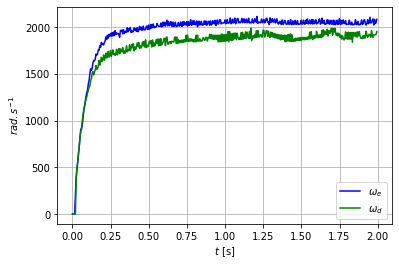

In [5]:
t = motor_e['TIME']
we= motor_e['OMEGA_RAW']
wd= motor_d['OMEGA_RAW']

plt.plot(t, we, '-b', label=r'$\omega_e$')
plt.plot(t, wd, '-g', label=r'$\omega_d$')

plt.ylabel(r'$rad.s^{-1}$')
plt.xlabel(r'$t$ [s]')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
def func(t,K,Tm):
    return K*(1.0 - np.exp(-t/Tm))

In [11]:
popt, pcov = curve_fit(func, t, we, bounds=([-10000., 0.01], [10000., 1000]))
popt

array([2.04287270e+03, 9.40546548e-02])

In [15]:
pcov

array([[3.90077775e+00, 5.38783225e-04],
       [5.38783225e-04, 6.52520451e-07]])

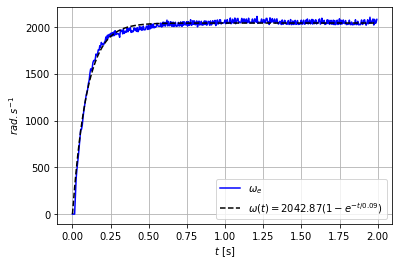

In [14]:
Ke = popt[0]
Tme= popt[1]

plt.plot(t, we, '-b', label=r'$\omega_e$')
plt.plot(t, func(t,Ke,Tme), '--k', label=r'$\omega(t) = %.2f\left( 1 - e^{-t/%.2f}\right)$'%(Ke,Tme))

plt.ylabel(r'$rad.s^{-1}$')
plt.xlabel(r'$t$ [s]')
plt.grid(True)
plt.legend()
plt.show()

# Ref. Teórico
## Sistema(Planta):
\begin{equation}
G(s) = \frac{Y(s)}{U(s)} = \frac{K}{T_ms + 1}
\end{equation}

\begin{equation}
y(t) = K(1 - e^{-t/T_m})
\end{equation}

\begin{equation}
\omega(t) = u(t)K\left( 1 - e^{-t/T_m} \right); u(t) \in \left[-1, 1\right]
\end{equation}

## Filtro de Kalman
### Sistema
\begin{equation}
\textbf{x}_k = F_x x_{k-1} + B_k u_k + w_k; w_k \sim N(0, Q_k)
\end{equation}
### Medição
\begin{equation}
z_k = H_k x_k + v_k; v_k \sim N(0, R_k)
\end{equation}

### Predição
$\check{x}_k = F_k \hat{x}_{k-1} + B_k u_k$

$\check{P}_k = F_k \hat{P}_{k-1} F^T_k + Q_k$ 
### Atualização
$K_k = \check{P}_k H^T \left( H_k \check{P}_k H^T_k + R_k\right)^{-1}$

$\hat{x}_k = \check{x}_k + K_k\left( z_k - H_k \check{x}_k \right)$

$\hat{P}_k = \left(I - KH_k \right)\check{P}_k$

## Filtro de Kalman para a nossa planta
\begin{cases}
\textbf{x}_k = \left[ \omega_k \right]\\
z_k = x_k = \omega_k\\
F_k = 1\\
H_k = 1
\end{cases}
### Medição
\begin{align*}
z_k = \omega_z = \frac{N}{\Delta t}.k
\end{align*}

$N$: Números de pulsos;

$k$: Constante para converter de quantidade de pulsos para $rad/s$.
### Predição
\begin{align*}
\check{x}_k &= \hat{x}_{k-1} + (u_k - \hat{x}_{k-1}) \left( 1 - e^{-\frac{\Delta t}{T_m}} \right)\\
\check{x}_k &= \hat{x}_{k-1} +  u^{'}_k \left( 1 - e^{-\frac{\Delta t}{T_m}} \right)\\
\check{P}_k &= \hat{P}_{k-1} + Q_k
\end{align*}

**Obs.:** $\Delta t = t_f - t_0$. $\Delta t$ é relativo ao sinal de entrada $u_k$, sendo $t_0$ o instante que o sinal é aplicado e $t_f$ o instante atual $k$.
### Atualização
\begin{align*}
K_k &= \check{P}_k \left( \check{P}_k + R_k \right)^{-1} = \frac{\check{P}_k}{\check{P}_k + R_k}\\
\hat{x}_k &= \check{x}_k + K_k \left( z_k - \check{x}_k \right)\\
\hat{P}_k &= \left( 1 - K_k \right) \check{P}_k
\end{align*}

In [94]:
# inicialização
p0 = 600
r = we[t >= Tme*5].var() #incerteza da medição
q = 50  #bias da incerteza (procurar uma definição mais adequada)
#############################################################
w_mean  = np.zeros_like(t)    #omega predito
w_check = np.zeros_like(t)    #omega predito
w_hat   = np.zeros_like(t)    #melhor estimativa de oemga (omega filtrado)
p_check = np.zeros_like(t)    #incerteza de omega
p_hat   = np.zeros_like(t)
K = np.zeros_like(t)         #ganho do filtro

p_check[0] = p_hat[0] = p0
##############################################################

#input
Tm= Tme
Kgain= Ke
u = 1.0*Kgain

for i in range(1, len(t)):
    # medição
    wz = we[i]
    w_mean[i] = (w_mean[i-1] + wz)/2.0
    
    # predição
    w_check[i] = w_hat[i-1] + (u - w_hat[i-1])*(1.0 - np.exp(-t[i]/Tm))
    p_check[i] = p_hat[i-1] + q
    
    # atualização
    K[i] = p_check[i]/(p_check[i]+r)
    w_hat[i] = w_check[i] + K[i]*(wz - w_check[i])
    p_hat[i] = (1 - K[i])*p_check[i]

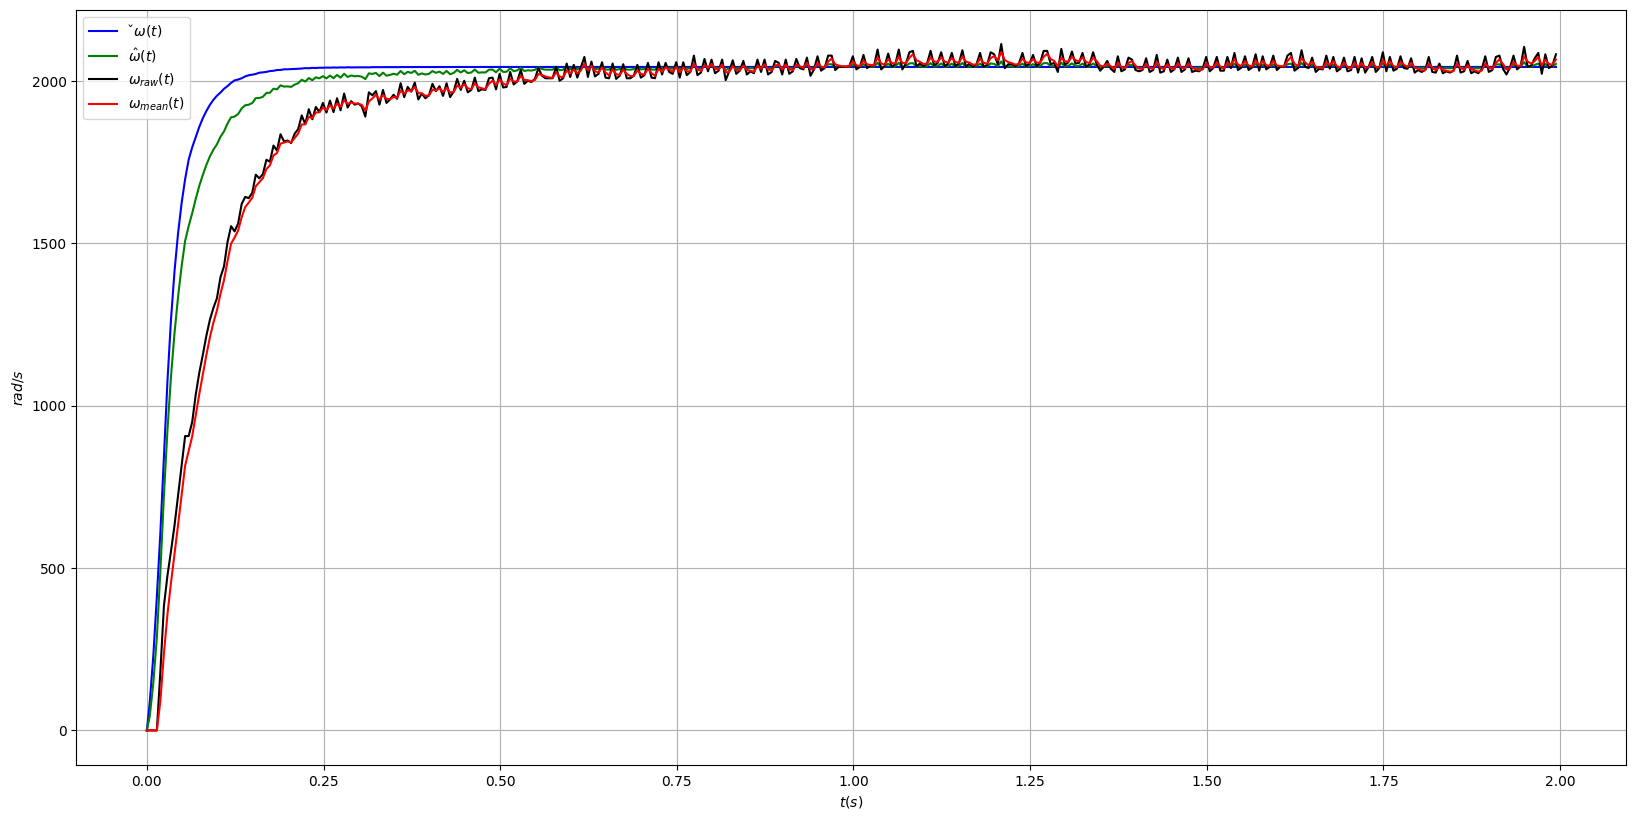

In [95]:
plt.figure(figsize=(20, 10), dpi=100)
plt.plot(t, w_check, '-b', label=r'$\check{\omega}(t)$')
plt.plot(t, w_hat, '-g', label=r'$\hat{\omega}(t)$')
plt.plot(t, we, '-k', label=r'$\omega_{raw}(t)$')
plt.plot(t, w_mean, '-r', label=r'$\omega_{mean}(t)$')
plt.ylabel(r'$rad/s$');
plt.xlabel(r'$t(s)$');
plt.legend();
plt.grid(True)
plt.show();

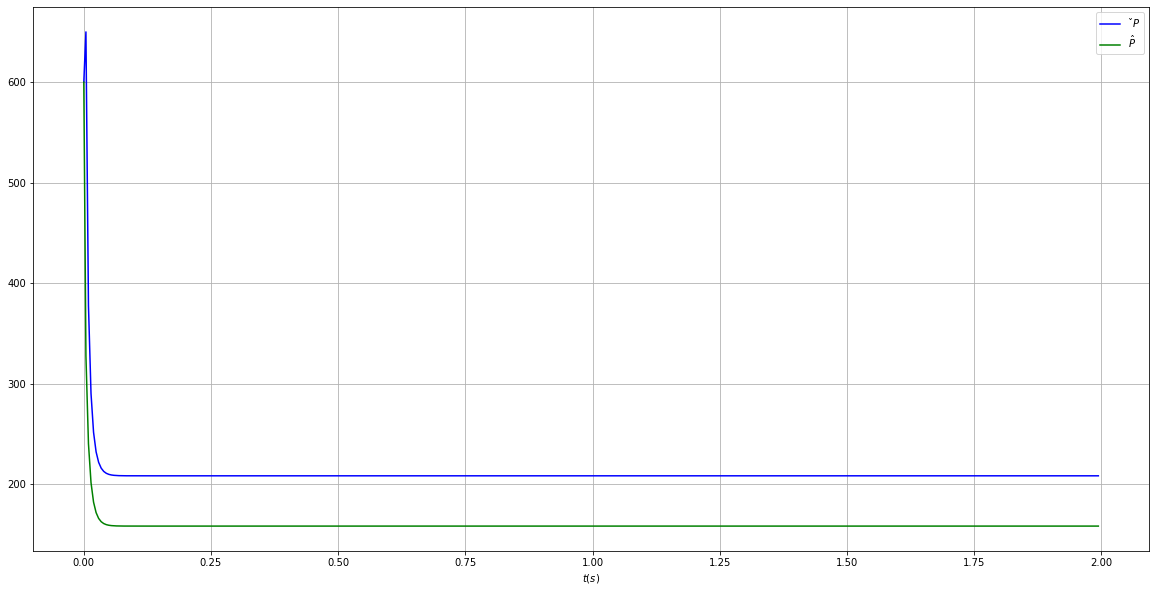

In [96]:
plt.figure(figsize=(20, 10))
# plt.plot(t, K, '-k', label=r'$K_{gain}$')
plt.plot(t, p_check, '-b', label=r'$\check{P}$')
plt.plot(t, p_hat, '-g', label=r'$\hat{P}$')
plt.xlabel(r'$t(s)$');
plt.legend();
plt.grid(True)
plt.show();

In [97]:
p_hat[-1]

158.54124665679748

In [66]:
w_hat[t >= Tm*5].var()

44.357842291297096